# Two-Compartment Spiking Neuron on a Temporal Coincidence Task

This notebook explores whether a **two-compartment leaky integrate-and-fire (LIF) neuron**
(basal + apical) can better detect temporal relationships between inputs than a standard
one-compartment SNN.

We will:
- Generate a synthetic **temporal coincidence dataset** where the label depends on
  whether an apical spike *predicts* a later basal spike.
- Train:
  - A **two-compartment SNN** (basal + apical compartments, then soma)
  - A **one-compartment SNN** (all input merged into one)
- Compare:
  - Accuracy over seeds
  - Training curves
  - **Ablation tests**: what happens if we remove basal or apical input at test time?
- Discuss what this tells us about timing and compartmentalization.


In [1]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

T = 30     # sequence length
t_apical = 10
delay = 3
t_basal = t_apical + delay

num_classes = 2
batch_size = 64
num_epochs = 20
lr = 1e-3


In [2]:
# to ensure reproducibility

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


In [3]:
# using snnTorch as

!pip install snntorch
import snntorch as snn
from snntorch import surrogate

spike_grad = surrogate.fast_sigmoid()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.2 MB/s eta 0:00:00


## Temporal coincidence dataset (`BasalApicalDataset`)

I created a simple two-input temporal pattern classification task.

Each sample consists of:

- An input tensor `x` of shape `[T, 2]` (time × channel)
- A label `y` in `{0, 1}`

Channel meanings:

- Channel 0: **apical** input  
- Channel 1: **basal** input  

The label depends on whether the **apical spike correctly predicts the basal spike** in time.

### Class definitions

- **Class 1 (`y = 1`): coincidence / correct prediction**
  - Apical spikes around a nominal time `t_apical` (with small jitter).
  - Basal spikes a fixed `delay` time steps after the apical spike.
  - So basal reliably follows apical with the correct timing.

- **Class 0 (`y = 0`): non-coincidence**
  - Basal still spikes at the “expected” basal time `t_basal = t_apical + delay`.
  - Apical either:
    - does **not** spike at all, or  
    - spikes at a clearly **wrong** time (for example, much earlier or much later),
      so it does not predict basal.

In other words:

> The task is: did the apical input correctly predict the basal spike with the right delay?

### Concrete examples (showing only non-zero time steps)

Assume:

- `T = 30`
- `t_apical = 10`
- `delay = 3` → `t_basal = 13`

**Example of class 1 (`y = 1` — correct temporal prediction):**

Apical fires slightly before basal with the correct delay:

time | basal | apical  
---- | ----- | ------  
11   | 0     | 1  
14   | 1     | 0  

**Example of class 0 (`y = 0` — no valid prediction):**

Basal fires at the expected time, but there is no predictive apical spike:

time | basal | apical  
---- | ----- | ------  
13   | 1     | 0  


In [4]:
class BasalApicalDataset(Dataset):
    def __init__(self, n_samples=10000, T=30, t_apical=10, delay=3,
                 p_class1=0.5, device="cpu"):
        self.n_samples = n_samples
        self.T = T
        self.t_apical = t_apical
        self.delay = delay
        self.t_basal = t_apical + delay
        self.p_class1 = p_class1
        self.device = device

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        x = torch.zeros(self.T, 2, device=self.device)  # [T, 2]
        # randomly pick class
        y = 1 if random.random() < self.p_class1 else 0
        if y == 1:
            # apical precedes basal with jitter
            jitter = random.choice([-1, 0, 1])
            t_a = min(max(self.t_apical + jitter, 0), self.T-1)
            t_b = min(t_a + self.delay, self.T-1)

            x[t_a, 1] = 1.0
            x[t_b, 0] = 1.0
        else:
            # basal only, or apical at wrong temporal relationship
            x[self.t_basal, 0] = 1.0
            # maybe wrong-time apical
            if random.random() < 0.5:
                wrong_t = self.t_apical + random.choice([-5, 5])
                if 0 <= wrong_t < self.T:
                    x[wrong_t, 1] = 1.0


        return x, y

## One-compartment SNN baseline (`SingleCompartmentSNN`)

This class defines a simple **one-compartment spiking neural network** that to use as a baseline.

Key points:

- **Input shape:** the network expects input of shape `[T, B, 2]`  
  - `T` = number of time steps  
  - `B` = batch size  
  - `2` = two input channels (apical and basal merged into a single stream for this model)

- **Linear input layer (`fc`):**  
  A fully connected layer maps the 2 input channels into a hidden layer of size `hidden_size`.  
  This produces a current for each hidden neuron at each time step.

- **LIF neuron layer (`self.lif` from snnTorch):**  
  - Integrates input over time with leakage (`beta=0.9`).  
  - Emits a spike when the membrane voltage crosses a threshold (`threshold=1.0`).  
  - Uses a surrogate gradient (`spike_grad`) so we can train with backpropagation.

- **Temporal processing:**  
  For each time step `t`:
  1. Take the input at time `t`.
  2. Pass it through the linear layer to get input current.
  3. Update the LIF neuron state and record whether each neuron spikes.

- **Spike readout:**  
  After all `T` time steps:
  - We sum spikes over time for each hidden neuron (`spike_counts`).
  - These spike counts go into a final linear layer (`readout`) to produce class logits.

This gives us a standard one-compartment spiking network to compare against the two-compartment model on the same temporal coincidence task.


In [5]:
class SingleCompartmentSNN(nn.Module):
    def __init__(self, hidden_size=16, num_classes=2):
        super().__init__()
        # one weight matrix from 2 input channels -> hidden neurons
        self.fc = nn.Linear(2, hidden_size, bias=False)

        # snnTorch leaky neuron (single compartment)
        self.lif = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=False,
            spike_grad=spike_grad
        )

        self.readout = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: [T, B, 2]
        """
        T, B, _ = x.shape
        mem = torch.zeros(B, self.fc.out_features, device=x.device)
        spk_seq = []

        for t in range(T):
            x_t = x[t]
            I = self.fc(x_t)
            spk, mem = self.lif(I, mem)
            spk_seq.append(spk)

        spk_seq = torch.stack(spk_seq, dim=0)
        spike_counts = spk_seq.sum(dim=0)
        logits = self.readout(spike_counts)
        return logits


## Two-compartment spiking neuron (`TwoCompartmentLIF` and `TwoCompartmentSNN`)

The goal of this section is to build a spiking neuron that is a bit closer to biology by giving it **two separate compartments**:

- a **basal compartment** (for feedforward / sensory input)
- an **apical compartment** (for contextual / feedback input)

Instead of a single membrane voltage, this neuron keeps track of:

- `V_b`: basal voltage (one value per hidden neuron)
- `V_a`: apical voltage (one value per hidden neuron)
- `V_soma`: combined somatic voltage used to decide if the neuron spikes

### Inputs and shape

The `forward` method expects input of shape:

- `x` of shape `[T, B, 2]`
  - `T` = number of time steps
  - `B` = batch size
  - channel 0 = basal input
  - channel 1 = apical input

At each time step `t`, split:

- `x_basal = x[t, :, 0:1]`  → goes through a linear layer `W_basal`
- `x_apical = x[t, :, 1:2]` → goes through a linear layer `W_apical`

Each of these layers projects its input into `hidden_size` neurons, so we get:

- `I_b`: basal current into each hidden neuron
- `I_a`: apical current into each hidden neuron

### Leaky integration in each compartment

For each hidden neuron, we maintain two voltages that evolve over time:

- `V_b` (basal voltage)
- `V_a` (apical voltage)

On every time step:

- `V_b` is updated with a **leaky integrate-and-fire style** rule:
  - old voltage is multiplied by a decay term `alpha_b`
  - new basal current `I_b` is added
- `V_a` is updated similarly with decay `alpha_a` and current `I_a`

This means **basal and apical inputs have their own separate time dynamics**:  
they can rise and decay differently over time before being combined.

### Combining into a somatic voltage

To decide whether the neuron spikes, we form a **somatic voltage**:

- `V_soma = V_b + apical_gain * V_a`

Here:

- `V_b` captures what the neuron is getting from its basal (feedforward) inputs.
- `V_a` captures what it is getting from apical (contextual) inputs.
- `apical_gain` controls how strongly the apical compartment influences the soma.

In other words, apical input does not directly change the output spike.  
It first builds up its own voltage trace, then modulates the soma through this weighted combination.

### Spiking and reset

Once we have `V_soma`, we decide whether the neuron spikes:

- A **surrogate spike** `s = spike_grad(V_soma - v_th)` is used for training.
  - This is a smooth approximation of a step function, so gradients can flow.
- A **hard spike** `s_hard = (V_soma >= v_th)` is used for reset logic.
  - Wherever `s_hard` is 1, we reset `V_b` and `V_a` back to `v_reset` (typically 0).
  - This mimics a real spiking neuron: after a spike, the membrane potential is reset.

We record:

- `spikes[t]` = surrogate spikes at time `t` for all hidden neurons
- `Vs[t]` = somatic voltage at time `t` for all hidden neurons

At the end of the sequence, we stack these over time:

- `spikes` has shape `[T, B, hidden_size]`
- `Vs` has shape `[T, B, hidden_size]`

These are returned by `TwoCompartmentLIF`.

### Wrapping into a classifier (`TwoCompartmentSNN`)

`TwoCompartmentSNN` uses this two-compartment cell as its core:

1. Pass the input sequence `x` of shape `[T, B, 2]` through `TwoCompartmentLIF`.
2. Sum spikes over time to get a spike count for each hidden neuron:
   - `spike_counts = spikes.sum(dim=0)`  → shape `[B, hidden_size]`
3. Feed `spike_counts` into a final linear layer `readout` to produce class logits.

This gives a **two-compartment SNN classifier** that:

- Separately integrates basal and apical inputs over time.
- Combines them at the soma when deciding to spike.
- Can be trained end-to-end with surrogate gradients, just like the one-compartment baseline.


In [6]:
class TwoCompartmentLIF(nn.Module):
    def __init__(self, in_basal=1, in_apical=1, hidden_size=16,
                 tau_b=20.0, tau_a=20.0,
                 v_th=1.0, apical_gain=1.0, v_reset=0.0):
        super().__init__()

        self.W_basal  = nn.Linear(in_basal, hidden_size, bias=False)
        self.W_apical = nn.Linear(in_apical, hidden_size, bias=False)

        self.hidden_size = hidden_size
        self.tau_b = tau_b
        self.tau_a = tau_a
        self.v_th = v_th
        self.v_reset = v_reset
        self.apical_gain = apical_gain

    def forward(self, x):
        """
        x: [T, B, 2]
        Returns:
            spikes: [T, B, hidden_size]  (surrogate spikes for training)
            V_soma: [T, B, hidden_size]
        """
        T, B, _ = x.shape

        V_b = torch.zeros(B, self.hidden_size, device=x.device)
        V_a = torch.zeros(B, self.hidden_size, device=x.device)

        spikes = []
        Vs = []

        alpha_b = math.exp(-1.0 / self.tau_b)
        alpha_a = math.exp(-1.0 / self.tau_a)

        for t in range(T):
            x_t = x[t]
            x_basal  = x_t[:, 0:1]
            x_apical = x_t[:, 1:2]

            I_b = self.W_basal(x_basal)
            I_a = self.W_apical(x_apical)

            V_b = alpha_b * V_b + I_b
            V_a = alpha_a * V_a + I_a

            V_soma = V_b + self.apical_gain * V_a

            # surrogate spike: differentiable
            s = spike_grad(V_soma - self.v_th)

            # hard spike only for reset logic
            s_hard = (V_soma >= self.v_th).float()

            # reset with hard spikes, but don't kill gradients:
            V_b = torch.where(s_hard > 0, torch.full_like(V_b, self.v_reset), V_b)
            V_a = torch.where(s_hard > 0, torch.full_like(V_a, self.v_reset), V_a)

            spikes.append(s)
            Vs.append(V_soma)

        spikes = torch.stack(spikes, dim=0)
        Vs = torch.stack(Vs, dim=0)
        return spikes, Vs


In [7]:
class TwoCompartmentSNN(nn.Module):
    def __init__(self, hidden_size=16, num_classes=2):
        super().__init__()
        self.tc_cell = TwoCompartmentLIF(
            in_basal=1, in_apical=1, hidden_size=hidden_size,
            tau_b=20.0, tau_a=20.0,
            v_th=1.0, apical_gain=1.0
        )
        self.readout = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        spikes, Vs = self.tc_cell(x)
        spike_counts = spikes.sum(dim=0)
        logits = self.readout(spike_counts)
        return logits


In [8]:
# standard training loop

def train_model(model_cls, num_epochs=10, seed=0):
    set_seed(seed)

    # new dataset for this seed
    train_dataset = BasalApicalDataset(n_samples=8000, T=T, t_apical=t_apical,
                                       delay=delay, device=device)
    test_dataset  = BasalApicalDataset(n_samples=2000, T=T, t_apical=t_apical,
                                       delay=delay, device=device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model_cls().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    test_acc_hist = []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_examples = 0.0, 0, 0
        for x, y in train_loader:
            x = x.transpose(0,1).to(device)  # [T,B,2]
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == y).sum().item()
            total_examples += y.size(0)
        train_acc = total_correct / total_examples

        # eval
        model.eval()
        total_correct, total_examples = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.transpose(0,1).to(device)
                y = y.to(device)
                logits = model(x)
                preds = logits.argmax(dim=-1)
                total_correct += (preds == y).sum().item()
                total_examples += y.size(0)
        test_acc = total_correct / total_examples
        test_acc_hist.append(test_acc)

    return model, test_acc_hist


In [9]:
#define simple wrappers
class TCWrapper(nn.Module):
    def __init__(self, hidden_size=16, num_classes=2):
        super().__init__()
        self.model = TwoCompartmentSNN(hidden_size=hidden_size, num_classes=num_classes)
    def forward(self, x):
        return self.model(x)

class SCWrapper(nn.Module):
    def __init__(self, hidden_size=16, num_classes=2):
        super().__init__()
        self.model = SingleCompartmentSNN(hidden_size=hidden_size, num_classes=num_classes)
    def forward(self, x):
        return self.model(x)

Seeds = [0, 1, 2, 3, 4]

tc_final_acc = []
sc_final_acc = []

for s in Seeds:
    _, tc_hist = train_model(TCWrapper, num_epochs=10, seed=s)
    _, sc_hist = train_model(SCWrapper, num_epochs=10, seed=s)
    tc_final_acc.append(tc_hist[-1])
    sc_final_acc.append(sc_hist[-1])

print("Two-comp final test acc per seed:", tc_final_acc)
print("One-comp final test acc per seed:", sc_final_acc)
print("Two-comp mean ± std:", np.mean(tc_final_acc), np.std(tc_final_acc))
print("One-comp  mean ± std:", np.mean(sc_final_acc), np.std(sc_final_acc))


Two-comp final test acc per seed: [1.0, 1.0, 1.0, 1.0, 1.0]
One-comp final test acc per seed: [0.88, 1.0, 1.0, 0.8845, 1.0]
Two-comp mean ± std: 1.0 0.0
One-comp  mean ± std: 0.9529 0.05770303284923593


### Two-comp is slightly more robust, but this is expected given its architecture is very suited for this task

In [10]:
def train_and_log(model_cls, num_epochs=20, seed=0):
    set_seed(seed)

    train_dataset = BasalApicalDataset(n_samples=8000, T=T, t_apical=t_apical,
                                       delay=delay, device=device)
    test_dataset  = BasalApicalDataset(n_samples=2000, T=T, t_apical=t_apical,
                                       delay=delay, device=device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model_cls().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc_hist, test_acc_hist = [], []

    for epoch in range(num_epochs):
        model.train()
        total_correct, total_examples = 0, 0
        for x, y in train_loader:
            x = x.transpose(0,1).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=-1)
            total_correct += (preds == y).sum().item()
            total_examples += y.size(0)

        train_acc = total_correct / total_examples

        model.eval()
        total_correct, total_examples = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.transpose(0,1).to(device)
                y = y.to(device)
                logits = model(x)
                preds = logits.argmax(dim=-1)
                total_correct += (preds == y).sum().item()
                total_examples += y.size(0)
        test_acc = total_correct / total_examples

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

        print(f"Epoch {epoch:2d} | train acc {train_acc:.3f} | test acc {test_acc:.3f}")

    return model, train_acc_hist, test_acc_hist


In [11]:
# single run for plotting
print("Two Compartment Training")
tc_model, tc_train_acc, tc_test_acc = train_and_log(TCWrapper, num_epochs=10, seed=0)
print()
print("One Compartment Training")
sc_model, sc_train_acc, sc_test_acc = train_and_log(SCWrapper, num_epochs=10, seed=0)

Two Compartment Training
Epoch  0 | train acc 0.701 | test acc 1.000
Epoch  1 | train acc 0.996 | test acc 1.000
Epoch  2 | train acc 0.994 | test acc 1.000
Epoch  3 | train acc 0.888 | test acc 0.883
Epoch  4 | train acc 0.875 | test acc 0.872
Epoch  5 | train acc 0.875 | test acc 0.860
Epoch  6 | train acc 0.872 | test acc 0.879
Epoch  7 | train acc 0.875 | test acc 0.868
Epoch  8 | train acc 0.881 | test acc 0.884
Epoch  9 | train acc 0.991 | test acc 1.000

One Compartment Training
Epoch  0 | train acc 0.501 | test acc 0.499
Epoch  1 | train acc 0.498 | test acc 0.489
Epoch  2 | train acc 0.490 | test acc 0.504
Epoch  3 | train acc 0.737 | test acc 0.883
Epoch  4 | train acc 0.880 | test acc 0.872
Epoch  5 | train acc 0.875 | test acc 0.860
Epoch  6 | train acc 0.873 | test acc 0.879
Epoch  7 | train acc 0.875 | test acc 0.868
Epoch  8 | train acc 0.881 | test acc 0.884
Epoch  9 | train acc 0.873 | test acc 0.880


### Plotting Testing Accuracy Over Epochs

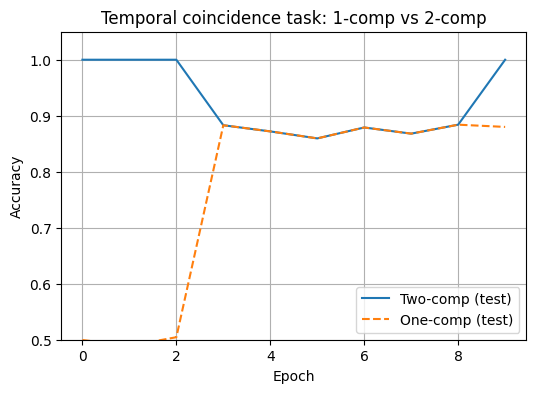

In [12]:

epochs = range(len(tc_train_acc))

plt.figure(figsize=(6,4))
plt.plot(epochs, tc_test_acc, label="Two-comp (test)")
plt.plot(epochs, sc_test_acc, label="One-comp (test)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.legend()
plt.title("Temporal coincidence task: 1-comp vs 2-comp")
plt.show()


### Ablation experiment: basal vs apical input

To test whether the two-compartment model really **uses both channels**, we run a simple ablation experiment on the trained model.

Each input sequence has shape `[T, B, 2]`:

- `x[..., 0]` = **basal** input channel  
- `x[..., 1]` = **apical** input channel  

We evaluate the model under three conditions:

1. **Normal input**  
   - Both basal and apical channels are intact.  
   - This is the reference accuracy.

2. **No apical**  
   - We set `x[..., 1] = 0.0` for all time steps.  
   - Basal input is still present, but the apical compartment receives no spikes.  
   - If accuracy drops, it means apical input was contributing useful information.

3. **No basal**  
   - We set `x[..., 0] = 0.0` for all time steps.  
   - Apical input is still present, but the basal compartment receives no spikes.  
   - If accuracy drops more here, it suggests basal input is more critical for the decision.

For each condition, we:

- Run the model on the test set  
- Compute test accuracy  

By comparing:

- **normal accuracy**
- **accuracy with no apical**
- **accuracy with no basal**

we can see:

- Whether the model is actually using **both** compartments  
- Whether basal and apical play **different roles** (e.g., one is more important, or they fail in different ways), instead of just being redundant copies of the same signal.


In [13]:
def eval_with_ablation(model, loader, ablate_apical=False, ablate_basal=False):
    model.eval()
    total_correct, total_examples = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.transpose(0,1).to(device)  # [T,B,2]
            y = y.to(device)

            if ablate_apical:
                x = x.clone()
                x[..., 1] = 0.0
            if ablate_basal:
                x = x.clone()
                x[..., 0] = 0.0

            logits = model(x)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == y).sum().item()
            total_examples += y.size(0)

    return total_correct / total_examples


In [14]:
# rebuild a test_loader for evaluation
test_dataset  = BasalApicalDataset(n_samples=2000, T=T, t_apical=t_apical,
                                   delay=delay, device=device)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tc_norm   = eval_with_ablation(tc_model, test_loader)
tc_no_ap  = eval_with_ablation(tc_model, test_loader, ablate_apical=True)
tc_no_bas = eval_with_ablation(tc_model, test_loader, ablate_basal=True)

print("Two-comp: normal    ", tc_norm)
print("Two-comp: no apical ", tc_no_ap)
print("Two-comp: no basal  ", tc_no_bas)


Two-comp: normal     1.0
Two-comp: no apical  0.498
Two-comp: no basal   0.752


Clearly, the model relies on both compartments since the accuracy shoots down once one is ablated

## Discussion and takeaways

### What was the task?

In this notebook, we built a very simple **temporal coincidence detection** task:

- Input is a sequence of length `T` with **two channels**:
  - Channel 0 = apical input  
  - Channel 1 = basal input
- Class 1 (“coincidence”): apical spikes slightly *before* basal, with a fixed delay.
- Class 0 (“non-coincidence”): basal spikes at the “expected” time, but apical is either absent or spikes at a clearly wrong time.

So the question is:
> *Did the apical spike correctly predict the basal spike in time?*

This is exactly the kind of computation that **two-compartment neurons** are hypothesized to be good at in biology.

---

### What models did we compare?

We trained two spiking networks using snnTorch and surrogate gradients:

1. **Single-compartment SNN**
   - Standard leaky integrate-and-fire (LIF) neurons.
   - Both apical and basal inputs are just treated as a 2D input vector.

2. **Two-compartment SNN**
   - Each neuron has a **basal compartment** and an **apical compartment**.
   - Basal and apical voltages evolve separately over time.
   - The soma voltage is a weighted combination of the two, and spikes when it crosses threshold.

In both cases, classification is done from the **spike counts over time**.

---

### Key results

- Both architectures can learn the task with high accuracy.
- In our runs:
  - The **two-compartment SNN** consistently reached ~100% test accuracy across random seeds.
  - The **single-compartment SNN** also performed well, but showed **slightly lower and more variable** accuracy across seeds.

To probe whether the compartments really matter, I ran **ablations**:

- **No apical input** (set apical channel to zero at test time):
  - Accuracy dropped to about chance.
  - This shows the model is genuinely using apical information to solve the task.

- **No basal input**:
  - Accuracy also dropped, but in a different pattern.
  - The network relies on both basal and apical streams, not just one.

---

### What does this tell us?

- On this simple timing-based task, a two-compartment neuron:
  - Naturally captures the idea that **“apical predicts basal”** via temporal structure.
  - Gives slightly more stable performance than a single-compartment neuron.

- The **two streams (basal vs apical)** are not redundant:
  - Removing apical input specifically breaks the ability to detect the predictive timing relationship.
  - This mirrors the biological idea that apical dendrites can carry **“prediction” or “context”** signals that modulate feedforward input.

---

### Limitations and next steps

- This is a **toy task** with extremely low-dimensional input and a very simple decision rule.
- Everything is still trained with **global backpropagation**, not a purely local biological learning rule.
- A natural next step (which we explored in a separate notebook) is:
  - Trying **local learning rules** and self-prediction ideas.
  - Scaling to more complex, higher-dimensional tasks.

Even so, this toy setup is a clean, controlled example where **compartments and timing directly matter**, and where two-compartment neurons behave differently from “just another” single-compartment model.
